In [2]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import pyswarms
import emcee
import corner
import os
#import arviz as az

#from pyswarms import pso  

In [3]:
print(os.getcwd())

/Users/gopipatel


In [4]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/Users/gopipatel/Documents/RRI_VSP/saras3_S11_200mm_above_water.s1p", skiprows=5))
d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]


In [5]:
c=3*10**8  # speed of light (m/s)
freq=[d[i][0] for i in range(len(d))] #frequency

# Function to measure TA

In [6]:
def Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    
    l=l
    freq= [d[i][0] for i in range(len(d))]
    for i in range(len(freq)):
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

# Chi2 DATA

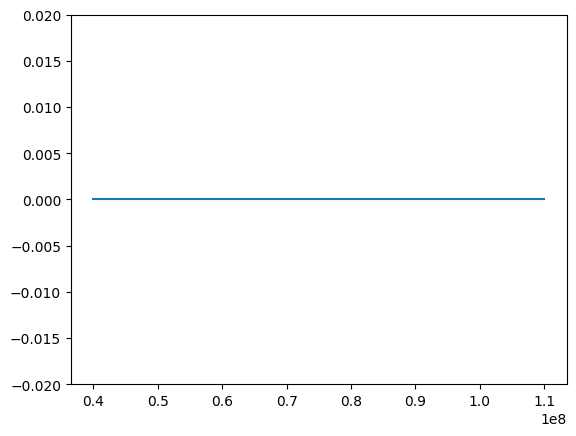

In [7]:
#Parameters
'''
PA  -------> Power at the Antenna terminal, can be open, short, load, and sky
PN  -------> Noise Power of the LNA in K 
P_ref  ----> Noise power from reference, considered to be ambient temperature
f ---------> Corr factor between the fwd and bkwd of the LNA, complex qty
gamma_A ---> Reflection Coeff. at the open terminal in db - Open
gamma_N ---> Reflection Coeff. at the LNA i/p (gamma N):10db
phi_A  ----> Phase of the wave reflected at the open terminal
phi_N  ----> phase of the noise wave
phi_f  ----> phase of the corr factor
'''

#simulated Tmeas

ip_params=[300,0,70,0.3,0.1,10]  #PA, gamma_A, PN, gamma_N, f, l
TA_exp=Compute_Tmeas_(*ip_params)#+np.random.normal(0,0.001,len(freq)) #adding Gaussian Noise
plt.ylim(-0.02,0.02)
plt.plot(freq,TA_exp)


### ChiSquare Function


In [6]:
def chi_squared(params):
    T_model = Compute_Tmeas_(*params) #Observed
    s=0.001                            #uncertainity
    chi2 = np.sum([((TA_exp[:] - T_model[:])/s)** 2 ])
    #chi2 = np.sum([((TA_exp[i] - T_model[i])/s)** 2  for i in range(len(freq))]) #least square fitting
    return chi2


## Minimising Chi2 

/var/folders/zm/pwt73btx1vzfr8smfkhs78c00000gn/T/ipykernel_1754/165737565.py:32: OptimizeWarning: Initial guess is not within the specified bounds
  result=scipy.optimize.minimize(chi_squared, initial_gues, method='Nelder-Mead', bounds=bounds)


1.1454762260617692


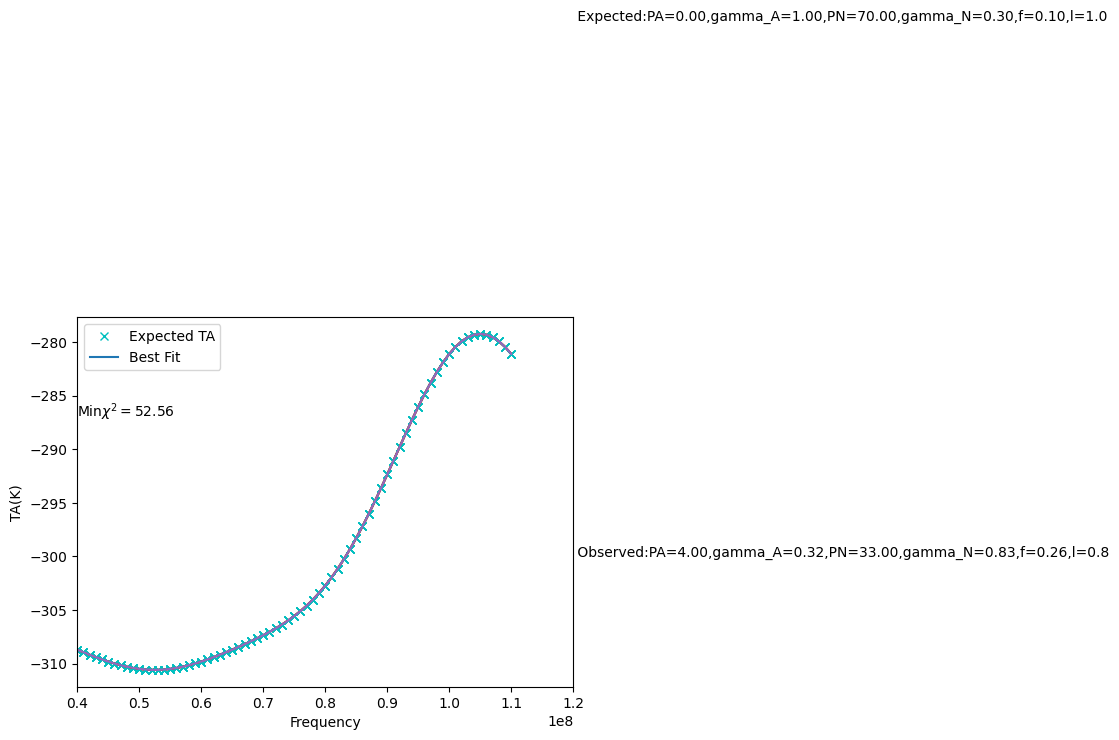

In [7]:
# Minimising Chi2 for fives sets of parameters
nt=5 
best_fit_params=[]
best_PA=[]
best_gamma_A=[]
best_PN=[]
best_gamma_N=[]
best_f=[]
best_l=[]
chi_2=[]
random.seed(17)

for n in range(nt):
    
    PA=random.randrange(0,5)
    gamma_A=random.uniform(-1,1)
    PN=random.randrange(5,150)
    gamma_N=random.uniform(-1,1)
    f=random.uniform(0.05,0.9)
    l=random.uniform(0.10,1)
    
    best_PA.append(PA)
    best_gamma_A.append(gamma_A)
    best_PN.append(PN)
    best_gamma_N.append(gamma_N)
    best_f.append(f)
    best_l.append(l)
    
    initial_gues=[PA,gamma_A,PN,gamma_N,f,l]  
    bounds=((0,5),(0,1),(50,150),(0,1),(0.05,0.5),(0.05,5)) #to return acceptable range for the params: PN, gamma_N, f, l

    result=scipy.optimize.minimize(chi_squared, initial_gues, method='Nelder-Mead', bounds=bounds)

    best_fit_params.append(result.x.tolist())
    TA_best_fit=Compute_Tmeas_(*result.x)
    
    chi_2.append(chi_squared(best_fit_params[n]).tolist())
    plt.plot(freq,TA_exp,"cx")
    plt.plot(freq,TA_best_fit)
    plt.legend(['Expected TA','Best Fit'])

m=min(chi_2)
#print(m)

i=chi_2.index(m)
plt.xlim(0.4e8,1.2e8)
plt.xlabel("Frequency")
plt.ylabel("TA(K)")
plt.annotate(r"Min$\chi^2={:.2f}$".format(min(chi_2)),xy=(0.4e8,-287))
plt.text(1.2e8, -250, r" Expected:PA={:.2f},gamma_A={:.2f},PN={:.2f},gamma_N={:.2f},f={:.2f},l={:.1f}".format(ip_params[0],ip_params[1],ip_params[2],ip_params[3],ip_params[4],ip_params[5]),fontsize = 10)
plt.text(1.2e8, -300, r" Observed:PA={:.2f},gamma_A={:.2f},PN={:.2f},gamma_N={:.2f},f={:.2f},l={:.1f}".format(best_PA[i],best_gamma_A[i],best_PN[i],best_gamma_N[i],best_f[i],best_l[i]),fontsize = 10)



df= 5 #6-1
s=0.05
print(scipy.stats.chi2.ppf(s, df))



## Error plots for each parameter

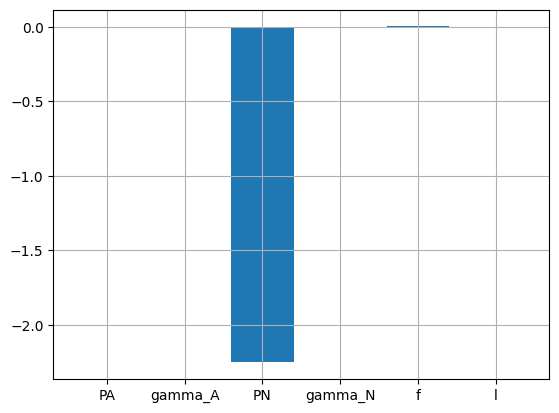

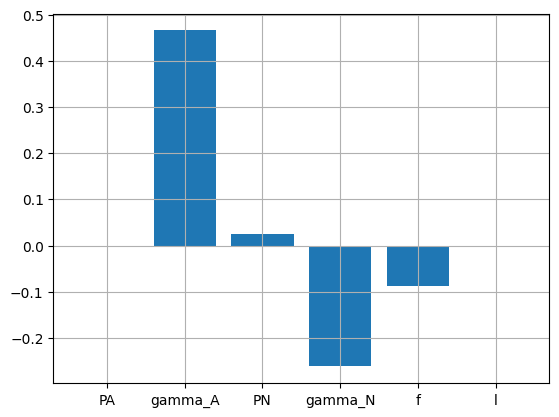

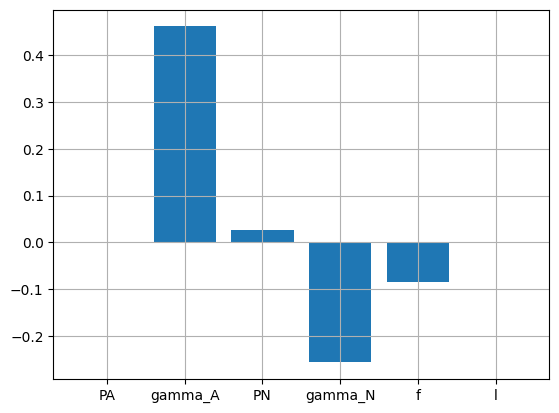

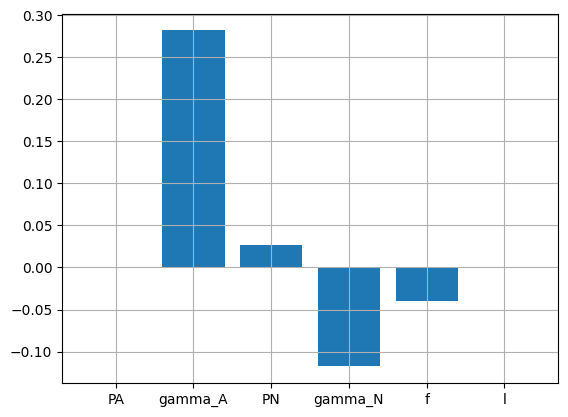

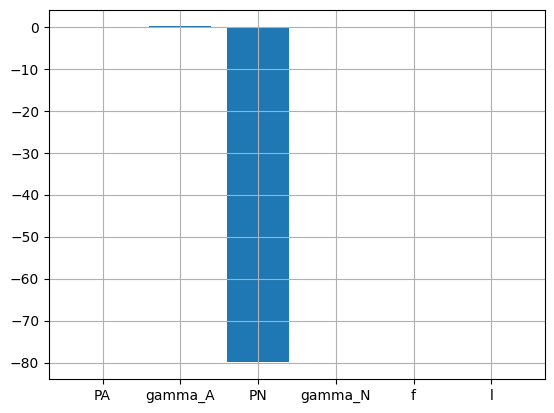

In [8]:
nt=5
for n in range(nt):
    err_PA=ip_params[0]-best_fit_params[n][0]
    err_gammaA=ip_params[1]-best_fit_params[n][1]   
    err_PN=ip_params[2]-best_fit_params[n][2]
    err_gammaN=ip_params[3]-best_fit_params[n][3]
    err_f=ip_params[4]-best_fit_params[n][4]
    err_l=ip_params[5]-best_fit_params[n][5]
    param = np.array(["PA","gamma_A","PN", "gamma_N", "f", "l"])


    err= np.array([err_PA, err_gammaA,err_PN, err_gammaN, err_f, err_l])

    plt.bar(param,err)
    plt.grid()
    plt.show()


# PSO

In [29]:
class pso_swarm:  
    '''
    min = [10.0, 10.0] -> lower limit on search parameters, it should be an
                           array of dimension of parameter space and sets
                            the lower limit along each dimension
    max = [10.0, 10.0] -> upper limit on search parameters, it should be an
                            array of dimension of parameter space and sets
                            the upper limit along each dimension
    vmin =[-1.0, -1.0] -> lower limit on velovity parameters, it should be an
                            array of dimension of parameter space and sets
                            the lower limit along each dimension
    vmax =[1.0, 1.0]   -> upper limit on velocity parameters, it should be an
                            array of dimension of parameter space and sets
                            the upper limit along each dimension
    dim               ->   dimension of search parameter space
    Nparticles        ->   Number of particles in the swarm
    Nsteps            ->   Maximum number of steps taken by the swarm
    curr_step         ->   Number of steps already taken by the swarm
    beta=0.3          ->   Beta parameter of PSO, couple to p_best
    gamma=0.4         ->   Gamma parameter of PSO, couple to g_best
    p_best            ->   Np x dim array
    g_best            ->   dim array
    pbest_corr        ->   Np array
    gbest_corr        ->   real
    x                 ->   position   Np x dim array
    v                 ->   velocity   Np x dim array
    particles         -> number of particle in the swarm
    steps             -> maximum number of steps taken by the swarm
'''
    def __init__(self,Nsteps,Nparticles,term_type,params,seed):
        #This function takes all that is needed to take one step as per PSO
        
        self.params=params
        self.term_type=term_type
        self.dim = 6                    #search dimensions       
        self.Nparticles=Nparticles      #number of particles
        self.Nsteps=Nsteps
        self.curr_step=0
        self.alpha=0.5                  #internia
        self.beta=0.3                   #nostalgia (acc. coeff.)
        self.gamma=0.4                  #social (acc. coeff.)
        self.freq= [d[i][0] for i in range(len(d))]
        self.fl = len(self.freq)
        self.T_model = np.zeros((self.Nparticles, self.fl))  # Observed TA initialization
        self.TA_exp=np.zeros(self.fl)
        parameters_names=["PA","gamma_A","PN","gamma_N","f","l"]
        self.min_values = [0.0, 0, 50.0, 0, 0.05, 0.05]        #minimum value of mass being scanned
        if self.term_type=='open' or self.term_type=='short':
            self.max_values= [3, 1, 150, 1, 0.5, 13] 
        else:
            self.max_values = [350, 1, 150, 1, 0.5, 13] #maximum value of mass being scanned for load terminal
        self.vmin =-1.0        ## Velocity limits
        self.vmax=1.0           ## Velocity limits
        #print(max_values[0])
        
        # Initialize positions and velocities
        np.random.seed(seed)
        self.x = np.random.uniform(low=self.min_values, high=self.max_values, size=(self.Nparticles, self.dim))
        self.v = np.random.uniform(low=self.vmin, high=self.vmax, size=(self.Nparticles, self.dim))
     
        # Fitness values
        self.chi2 = np.zeros(self.Nparticles)
        self.pbest_chi2 = np.full(self.Nparticles, np.inf)  # Set to a high value initially
        self.pbest = np.copy(self.x)  # Store best positions
        self.gbest = np.zeros(self.dim)
        self.gbest_chi2 = np.inf  # Set to high value initially
        self.gbest_chi2_step = np.zeros(self.Nsteps)
        
    def compute_fitness(self):
        #function that is optimized
        
        s = 0.001  # Uncertainty
        inp_p=self.params
        self.TA_Exp = Compute_Tmeas_(*inp_p)+ np.random.normal(0,0.001,len(self.freq))  # Expected TA values
        
        for j in range(self.Nparticles):
            p = self.x[j, :].tolist()
            self.T_model[j, :] = Compute_Tmeas_(*p)+ np.random.normal(0,0.001,len(self.freq))   # Simulated values
            # Define weight vector (modify based on parameter sensitivity)
            #w = np.array([1.2, 0.8, 1.0, 0.9, 1.5, 1.1])
            
            self.chi2[j] = np.sum(((self.TA_Exp - self.T_model[j, :]) / s) ** 2)  # Least squares
        return self.chi2
    
    ##########################################################################
    def compute_pbest(self):
        #This function find the best postion for a given particle
    
        for jj in range (self.Nparticles): ## Finds pbest
            if (self.chi2[jj]<self.pbest_chi2[jj]):
                self.pbest[jj,:] = self.x[jj,:]
                self.pbest_chi2[jj] = self.chi2[jj]
    
    ##########################################################################
    def compute_gbest(self):
        #This function finds the global best position found by all particles
    
        idbest= np.argmin(self.pbest_chi2)
        if self.pbest_chi2[idbest] < self.gbest_chi2 :
            self.gbest[:]=self.pbest[idbest,:]
            self.gbest_chi2=self.pbest_chi2[idbest]
        return self.gbest
    ##########################################################################
    def evolve_velocity(self):
        #This function evolves the velocity as per the standard PSO rule
        
        #np.random.seed(11)
        r0 = np.random.uniform(0,1)
        r1 = np.random.uniform(0,1)
        r2 = np.random.uniform(0,1)
        for jj in range (self.Nparticles):
            self.v[jj,:] = self.alpha*r0*self.v[jj,:] +\
            self.beta*r1*(self.pbest[jj,:]-self.x[jj,:]) +\
            self.gamma*r2*(self.gbest-self.x[jj,:])
    
    ##########################################################################
    def evolve_position(self):
        '''
            This evolves the position of the particle for a given velocity
            This function also updates the current step, a variable keeps
            track of the number of steps taken
        '''
        for jj in range(self.Nparticles):
            self.x[jj,:]=self.x[jj,:]+self.v[jj,:]
            
            # Clip values to stay within the allowed range
            #x[jj, :] = np.clip(x[jj, :], min_values, max_values)
            if (self.x[jj,kk]< self.min_values[kk] or self.x[jj,kk]>self.max_values[kk] for kk in range(self.dim)):
                self.chi2[jj]=np.inf
        
        self.curr_step+=1
    
    ##########################################################################
    def store_gbest(self) :
        #This function stores gbest for that particluar step
       
        if self.curr_step < self.Nsteps:  # Prevent out-of-bounds error
            self.gbest_chi2_step[self.curr_step] = self.gbest_chi2
    
    
    ##########################################################################
    def evolve_pso(self) :
      
        for n in range(self.Nsteps): #evolution
            self.compute_fitness()
            self.compute_pbest()
            self.compute_gbest()
            self.store_gbest()
            self.evolve_velocity()
            self.evolve_position()
            #print(f"Best Fitness: {gbest_chi2}, itr:{n+1}")#, Best Fit Paramaters:{gbest}, Expected Parameters:{params}")
        return self.gbest

## Evolve PSO

Expected: [300, 0, 70, 0.3, 0.1, 10]
Observed: [2.99993084e+02 1.59052186e-05 9.17076765e+01 6.46625237e-01
 1.15479274e-01 2.13597391e+00]


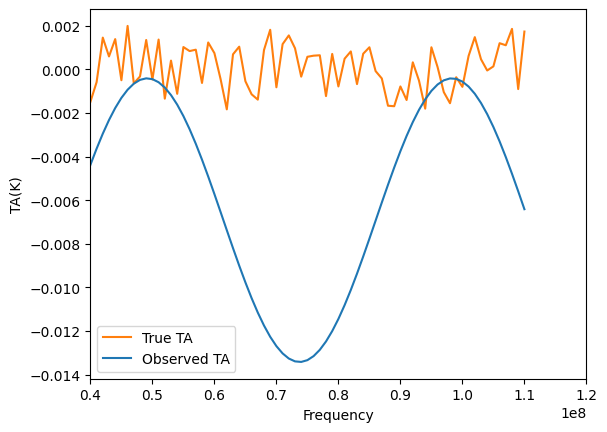

In [30]:
#evolve PSO
params=[300,0,70,0.3,0.1,10] #input parameters
Nsteps=30
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="load", params=params,seed=25)
best_fit = pso.evolve_pso()
print("Expected:",params)
print("Observed:",best_fit)

Best_Fit_TA=Compute_Tmeas_(*best_fit) #Observed TA
TA_Exp = Compute_Tmeas_(*params)+ np.random.normal(0,0.001,len(freq))  # Expected TA values

plt.plot(freq,TA_Exp, 'C1', label="True TA")
plt.plot(freq,Best_Fit_TA,label="Observed TA")

y=np.array(Best_Fit_TA)
TA_exp=np.array(TA_Exp)
yerr=abs(TA_exp-y)
#plt.errorbar(freq, y, yerr=yerr, fmt=".C7", capsize=0, label="error")
plt.xlim(0.4e8,1.2e8)
plt.xlabel("Frequency")
plt.ylabel("TA(K)")
plt.savefig('load_1m_')
plt.legend()

#plt.annotate(r"Min$\chi^2={:.2f}$".format(gbest_chi2),xy=(1.1e8,0.01))
#plt.text(1.2e8, 0.03, r" Expected:PA={:.2f},gamma_A={:.2f},PN={:.2f},gamma_N={:.2f},f={:.2f},l={:.1f}".format(params[0],params[1],params[2],params[3],params[4],params[5]),fontsize = 10)
#plt.text(1.2e8, 0.02, r" Observed:PA={:.2f},gamma_A={:.2f},PN={:.2f},gamma_N={:.2f},f={:.2f},l={:.1f}".format(gbest[0],gbest[1],gbest[2],gbest[3],gbest[4],gbest[5]),fontsize = 10)


2025-03-24 12:12:22,042 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,093 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,120 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,168 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,413 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,434 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,474 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,501 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,525 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,549 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,586 - root - WARNING - Too few points to create valid contours
2025-03-24 12:12:22,612 - root - WARNING - Too few points to create valid contours
2025

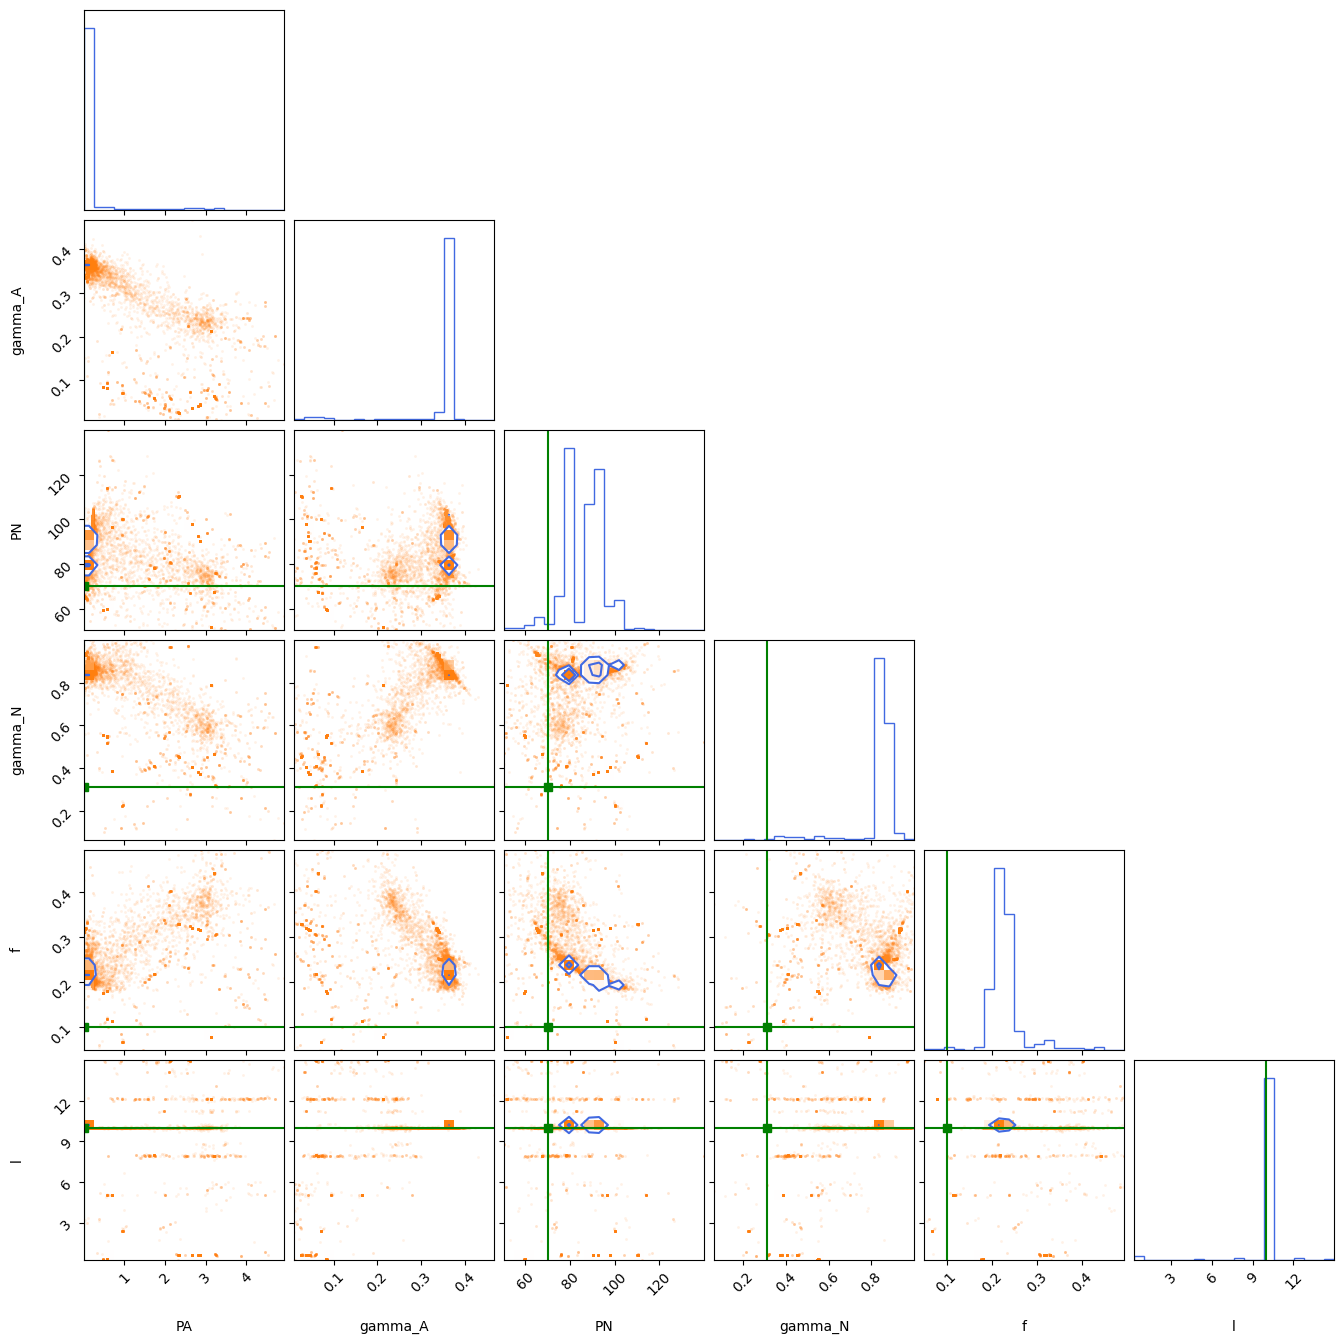

In [44]:
parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.show()


In [ ]:
'''
nt=100
for n in range(nt):
    params=[0,1,70,0.3,0.1,1]
    evolve_standard_pso(10,params)
    PA, gamma_A, PN, gamma_N, f, l=gbest  
    TA_fit=Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l)
    plt.plot(freq,TA_fit ,"C1", alpha=0.1)
plt.plot(freq, TA_exp, "r", alpha=0.3, lw=3, label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("freq")
plt.ylabel("TA(K)")
'''

## Open, Short and Load PSO Comparison

In [ ]:
#open,short and load comparison
################ open
type='open'
params=[0,1,70,0.3,0.1,1]
TA_Actual_open_1m= Compute_Tmeas_(*params)
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="open", params=params)
open_1m=pso.evolve_pso()
TA_obs_open_1m=Compute_Tmeas_(*open_1m)

params=[0,1,70,0.3,0.1,0.1]
TA_Actual_open_1cm= Compute_Tmeas_(*params)
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="open", params=params)
open_1cm=pso.evolve_pso()
TA_obs_open_1cm=Compute_Tmeas_(*open_1cm)
################ short
type='short'
params=[0,-1,70,0.3,0.1,1]
TA_Actual_short_1m= Compute_Tmeas_(*params)
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="open", params=params)
short_1m=pso.evolve_pso()
TA_obs_short_1m=Compute_Tmeas_(*short_1m)

params=[0,-1,70,0.3,0.1,0.1]
TA_Actual_short_1cm= Compute_Tmeas_(*params)
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="open", params=params)
short_1cm=pso.evolve_pso()
TA_obs_short_1cm=Compute_Tmeas_(*short_1cm)
################ load
type='load'
params=[300,0,70,0.3,0.1,1]
TA_Actual_load_1m= Compute_Tmeas_(*params)
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="load", params=params)
load_1m=pso.evolve_pso()
TA_obs_load_1m=Compute_Tmeas_(*load_1m)

params=[300,0,70,0.3,0.1,0.1]
TA_Actual_load_1cm= Compute_Tmeas_(*params)
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="load", params=params)
load_1cm=pso.evolve_pso()
TA_obs_load_1cm=Compute_Tmeas_(*load_1cm)
################# plots
plt.subplot(3,2,1)
plt.plot(freq,TA_Actual_open_1m)
plt.plot(freq,TA_obs_open_1m)
plt.title('Open (1m)')

plt.subplot(3,2,2)
plt.plot(freq,TA_Actual_open_1cm)
plt.plot(freq,TA_obs_open_1cm)
plt.title('Open (1cm)')

plt.subplot(3,2,3)
plt.plot(freq,TA_Actual_short_1m)
plt.plot(freq,TA_obs_short_1m)
plt.title('Short (1m)')

plt.subplot(3,2,4)
plt.plot(freq,TA_Actual_short_1cm)
plt.plot(freq,TA_obs_short_1cm)
plt.title('Short (1cm)')

plt.subplot(3,2,5)
plt.plot(freq,TA_Actual_load_1m)
plt.plot(freq,TA_obs_load_1m)
plt.title('Load (1m)')

plt.subplot(3,2,6)
plt.plot(freq,TA_Actual_load_1cm)
plt.plot(freq,TA_obs_load_1cm)
plt.title('Load (1cm)')


## PSO Convergence with steps

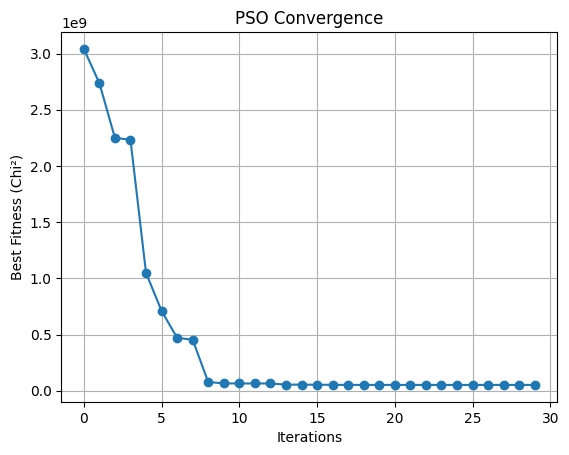

In [45]:
plt.plot(range(Nsteps), pso.gbest_chi2_step, marker='o', linestyle='-')
plt.xlabel("Iterations")
plt.ylabel("Best Fitness (Chi²)")
plt.title("PSO Convergence")
plt.grid(True)
plt.show()

## Pairplot (Parameter relationships)

In [ ]:
# Convert data to DataFrame for easy visualization
df = pd.DataFrame(pso.pbest, columns=["PA","gamma_A","PN","gamma_N","f","l"])
df["Fitness"] = pso.chi2

# Pairplot to visualize parameter relationships
sns.pairplot(df, diag_kind="kde")
plt.show()

## Parameter Correlation Heatmap

In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f",vmin=-1, vmax=1)
plt.title("Parameter Correlation Heatmap")
plt.show()

# MCMC

In [35]:
def evolve_MCMC(ip_params, type,nsteps, initial_value):# Define parameter names
    parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
    inp_params=ip_params
    # Define bounds for parameters
    min_values = [0.0, 0.0, 50.0, 0.0, 0.05,0.05]
    if type=='open' or type=='short':
        max_values= [5, 1, 150, 1,0.5, 13] 
    else:
        max_values = [350, 1, 150, 1, 0.5, 13] #maximum value of mass being scanned for load terminal
    
    
    # Define the Expected TA values
    TA_exp = Compute_Tmeas_(*inp_params) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    ########## Define the log-likelihood function
    def log_likelihood(params):
        PA, gamma_A, PN, gamma_N, f, l = params
    
        # Compute model TA
        TA_model = Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f,  l) # + np.random.normal(0,0.001,len(freq))
        TA_model=np.array(TA_model)

        # Compute chi-squared with weights
        s = 0.001  # Uncertainty
        chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 
    
        return -0.5*chi2 -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s) #+ np.log(s**2) # Likelihood function
    
    ########## Define the log-prior function
    def log_prior(params):
        
        PA, gamma_A, PN, gamma_N, f, l = params
        """
        # Check if params are within bounds
        if 0.0 < PA < 5 and 0.0 < gamma_A < 1.0 and 5.0 < PN < 100.0 and 0.0 < gamma_N < 1.0 and 0.05 < f < 0.9 and 0.1 < l < 1.0:
            return 0.0
        return -np.inf
        """
    
        
        for p, min_v, max_v in zip(params, min_values, max_values):
            if not (min_v <= p <= max_v):
                return -np.inf  # Reject sample
        return 0.0  # Uniform prior
        
    
    ######### Define the full log-probability function
    
    def log_probability(params):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)
    
    # Number of walkers and steps
    ndim = 6  # Number of parameters
    nwalkers = 150  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    # Initialize walkers around a random point in parameter space
    #initial = np.array([np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)])
    
    #initial = np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)])
    #initial_value=np.array([300.0,0.0,70,0.3,0.1,1])
    initial_value= np.array(initial_value)
    
    ########## Starting positions for the walkers
    #pos = initial 
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(pm,(1+1e-1)*pm) for pm in inp_params] for _ in range(nwalkers)])
    pos= initial_value[None,:] + initial_value*1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    #ind_pos = pos<0
    #pos[ind_pos] = np.abs(1e-1*np.random.randn(nwalkers, ndim))

    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 
    
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=500, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [36]:
#evolve MCMC
ip_params=[0,1,70,0.312,0.1,1] #input parameters
chains=3
nsteps=3000
#initials=[325,0.01,69.3,0.3,0.099,9.5]
initials=[0.2,0.92,60,0.3,0.1,0.75]
#initials=best_fit
full_samples, samples, best_fit_params= evolve_MCMC(ip_params,type='open',nsteps=nsteps, initial_value=initials)

Running MCMC...


  0%|                                                  | 0/3000 [00:00<?, ?it/s]/Users/gopipatel/my_env/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 3000/3000 [05:10<00:00,  9.66it/s]


2025-03-25 15:37:42,749 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:42,817 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:42,851 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:42,957 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,009 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,029 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,064 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,088 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,109 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,140 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,183 - root - WARNING - Too few points to create valid contours
2025-03-25 15:37:43,205 - root - WARNING - Too few points to create valid contours
2025

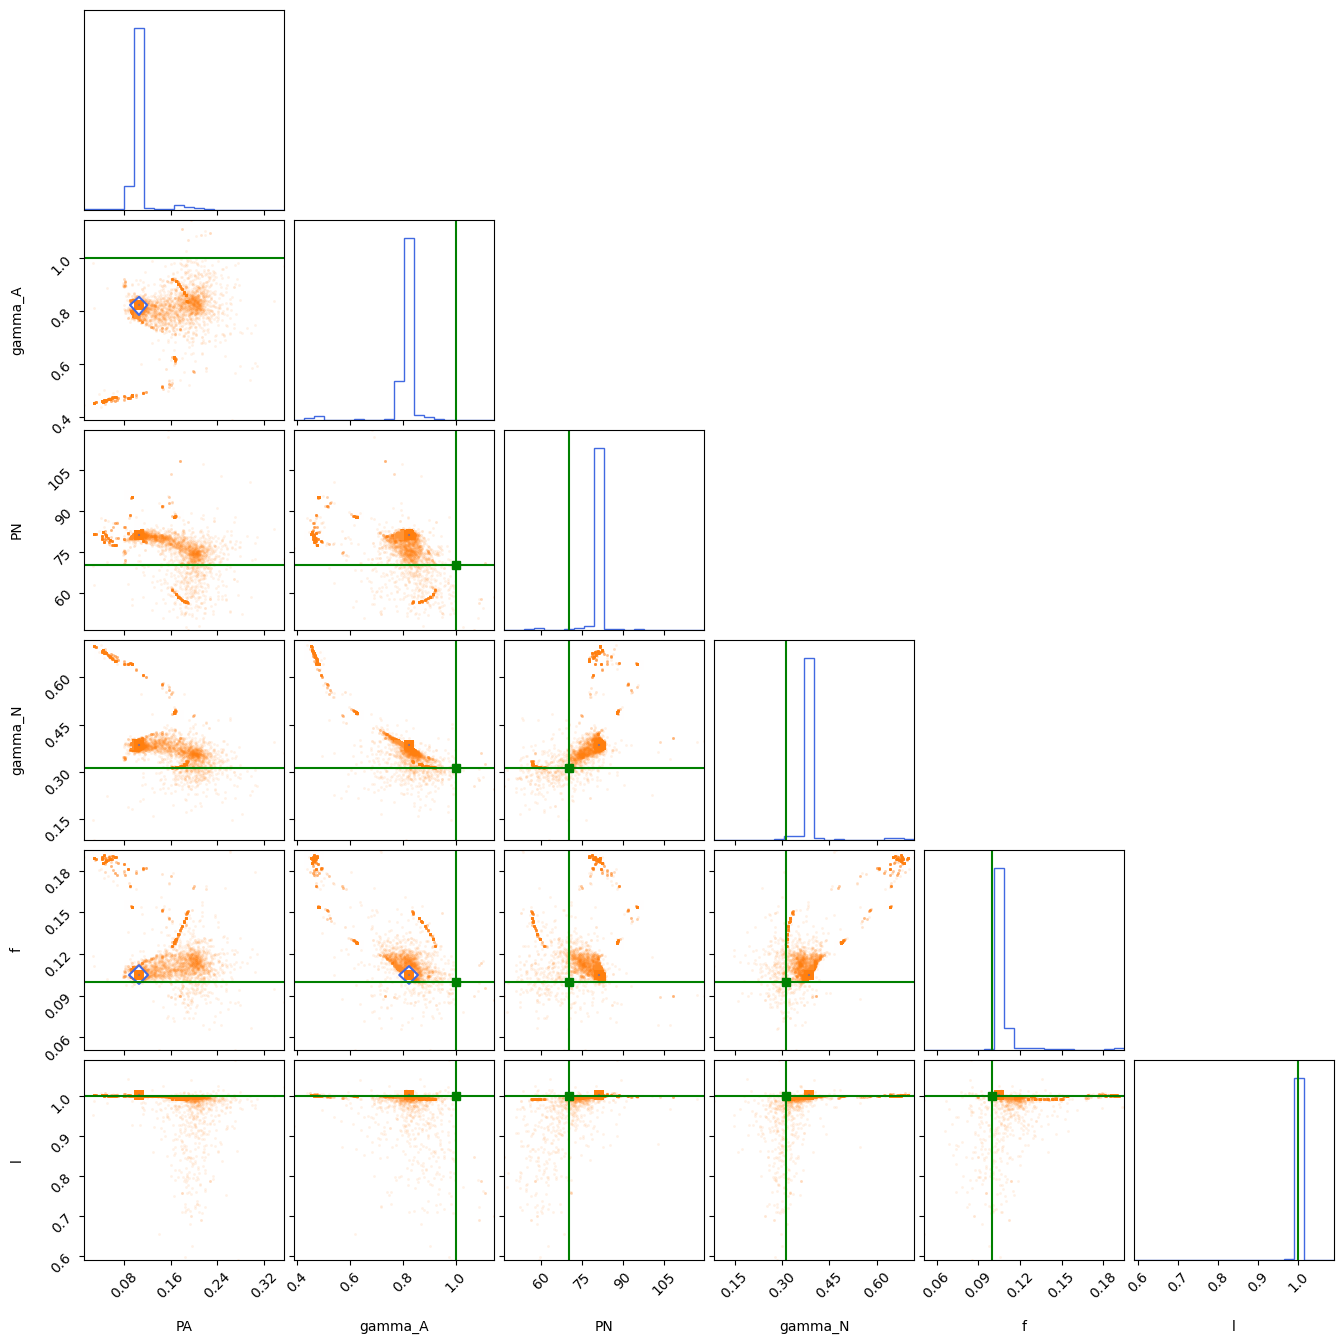

Best-fit parameters (Maximum Likelihood Estimate): [0.1064748466173917, 0.8141626432484039, 82.51738753252056, 0.3831876035275558, 0.1041953517072426, 0.999992798380913]


In [37]:
#avoiding negative values and no changes in the likelihood
#chi2 limit and initial exct+random
parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
#plt.savefig('/Users/gopipatel/Desktop/MCMC_load.png', dpi=300)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params)

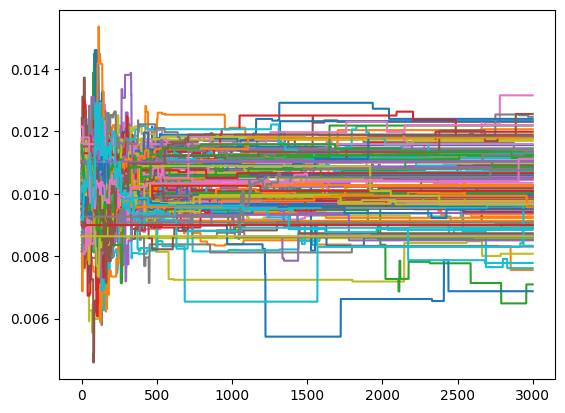

In [65]:
#samples.shape
plt.plot(full_samples[:,:,0])
plt.show()

In [ ]:

# Compute Gelman-Rubin diagnostic (R-hat)
az.rhat(sampler.get_chain())

# Compute Effective Sample Size (ESS)
az.ess(sampler.get_chain())

# Plot trace plots
az.plot_trace(sampler.get_chain())

## Errorplot and o/p for 100 random samples

In [ ]:
#plotting 100 samples

nt=100
for n in range(nt):
    PA, gamma_A, PN, gamma_N, f, l=samples[n+100,0,:]  
    TA_fit=Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l)
    plt.plot(freq,TA_fit ,"C1", alpha=0.1)
yerr=[]
y=np.array(Compute_Tmeas_(*best_fit_params))
TA_exp=np.array(TA_exp)
yerr=abs(TA_exp-y)
plt.errorbar(freq, y, yerr=yerr, fmt=".C7", capsize=0, label="error")
plt.plot(freq, TA_exp, "r", alpha=0.3, lw=3, label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

##### 

# PSO and MCMC Comparison

## Errorplots 

In [ ]:
#Comparison between PSO and MCMC
TA_exp=np.array(TA_exp)
TA_obs_PSO=np.array(Compute_Tmeas_(*best_fit))
TA_obs_MCMC=np.array(Compute_Tmeas_(*best_fit_params))
yerr_PSO=abs(TA_exp-TA_obs_PSO)
yerr_MCMC=abs(TA_exp-TA_obs_MCMC)
plt.errorbar(freq, TA_obs_PSO, yerr=yerr_PSO, fmt=".C7", capsize=0, label="PSO error")
plt.errorbar(freq, TA_obs_MCMC, yerr=yerr_MCMC, fmt="C9+", capsize=0, label="MCMC error")
plt.plot(freq, TA_exp, "r", alpha=0.3, lw=6, label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.xlabel("Frequency")
plt.ylabel("TA(K)")
plt.savefig("load_1m_PSO_MCMC.png")

## Estimated Parameter Values for 1m Open, Short and Load by PSO and MCMC

### Open 1m

In [ ]:
#Observed Value comparison between PSO and MCMC for open 1m
ip_params=[0,1,70,0.312,0.1,1]
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="open", params=ip_params)
obs_params_pso=pso.evolve_pso()
obs_params_mcmc= evolve_MCMC(ip_params,type='open')[1]
Errors_PSO=[ip - ob for ip, ob in zip(ip_params, obs_params_pso)]
Errors_MCMC=[ip - ob for ip, ob in zip(ip_params, obs_params_mcmc)]

data = np.array([['Expected',*ip_params],
                ['Open_1m_PSO',*obs_params_pso],
                ['Open_1m_MCMC',*obs_params_mcmc],
                ['Errors in PSO:',*Errors_PSO],
                ['Errors in MCMC:',*Errors_MCMC]])
                
print(pd.DataFrame(data, columns=['Parameters','PA','Gamma_A','PN','Gamma_N','f','length']))

### Short 1m

In [ ]:
#Observed Value comparison between PSO and MCMC for short 1m
ip_params=[0,-1,70,0.312,0.1,1]
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="short", params=ip_params)
obs_params_pso=pso.evolve_pso()
obs_params_mcmc= evolve_MCMC(ip_params,type='short')[1]
Errors_PSO=[ip - ob for ip, ob in zip(ip_params, obs_params_pso)]
Errors_MCMC=[ip - ob for ip, ob in zip(ip_params, obs_params_mcmc)]

data = np.array([['Expected',*ip_params],
                ['Short_1m_PSO',*obs_params_pso],
                ['Short_1m_MCMC',*obs_params_mcmc],
                ['Errors in PSO:',*Errors_PSO],
                ['Errors in MCMC:',*Errors_MCMC]])
                
print(pd.DataFrame(data, columns=['Parameters','PA','Gamma_A','PN','Gamma_N','f','length']))



### Load 1m

In [ ]:
#Observed Value comparison between PSO and MCMC for load 1m
ip_params=[300,0,70,0.312,0.1,1]
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="load", params=ip_params)
obs_params_pso=pso.evolve_pso()
obs_params_mcmc=evolve_MCMC(ip_params,type='load')[1]

Errors_PSO=[ip - ob for ip, ob in zip(ip_params, obs_params_pso)]
Errors_MCMC=[ip - ob for ip, ob in zip(ip_params, obs_params_mcmc)]

data = np.array([['Expected',*ip_params],
                ['Load_1m_PSO',*obs_params_pso],
                ['Load_1m_MCMC',*obs_params_mcmc],
                ['Errors in PSO:',*Errors_PSO],
                ['Errors in MCMC:',*Errors_MCMC]])
                
print(pd.DataFrame(data, columns=['Parameters','PA','Gamma_A','PN','Gamma_N','f','length']))

## Estimated Parameter Values for 1m Open, Short and Load by PSO and MCMC

### Open 10cm

In [ ]:
#Observed Value comparison between PSO and MCMC for open 10cm
ip_params=[0,1,70,0.312,0.1,0.1]
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="open", params=ip_params)
obs_params_pso=pso.evolve_pso()
obs_params_mcmc= evolve_MCMC(ip_params,type='open')[1]
Errors_PSO=[ip - ob for ip, ob in zip(ip_params, obs_params_pso)]
Errors_MCMC=[ip - ob for ip, ob in zip(ip_params, obs_params_mcmc)]

data = np.array([['Expected',*ip_params],
                ['Open_10cm_PSO',*obs_params_pso],
                ['Open_10cm_MCMC',*obs_params_mcmc],
                ['Errors in PSO:',*Errors_PSO],
                ['Errors in MCMC:',*Errors_MCMC]])
                
print(pd.DataFrame(data, columns=['Parameters','PA','Gamma_A','PN','Gamma_N','f','length']))

### Short 10cm

In [ ]:
#Observed Value comparison between PSO and MCMC for short 10cm
ip_params=[0,-1,70,0.312,0.1,0.1]
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="short", params=ip_params)
obs_params_pso=pso.evolve_pso()
obs_params_mcmc= evolve_MCMC(ip_params,type='short')[1]
Errors_PSO=[ip - ob for ip, ob in zip(ip_params, obs_params_pso)]
Errors_MCMC=[ip - ob for ip, ob in zip(ip_params, obs_params_mcmc)]

data = np.array([['Expected',*ip_params],
                ['Short_10cm_PSO',*obs_params_pso],
                ['Short_10cm_MCMC',*obs_params_mcmc],
                ['Errors in PSO:',*Errors_PSO],
                ['Errors in MCMC:',*Errors_MCMC]])
                
print(pd.DataFrame(data, columns=['Parameters','PA','Gamma_A','PN','Gamma_N','f','length']))

### Load 10cm

In [ ]:
#Observed Value comparison between PSO and MCMC for Load 10cm
ip_params=[300,0,70,0.312,0.1,0.1]
pso = pso_swarm(Nsteps=30, Nparticles=200, term_type="load", params=ip_params)
obs_params_pso=pso.evolve_pso()
obs_params_mcmc= evolve_MCMC(ip_params,type='load')[1]
Errors_PSO=[ip - ob for ip, ob in zip(ip_params, obs_params_pso)]
Errors_MCMC=[ip - ob for ip, ob in zip(ip_params, obs_params_mcmc)]

data = np.array([['Expected',*ip_params],
                ['Load_10cm_PSO',*obs_params_pso],
                ['Load_10cm_MCMC',*obs_params_mcmc],
                ['Errors in PSO:',*Errors_PSO],
                ['Errors in MCMC:',*Errors_MCMC]])
                
print(pd.DataFrame(data, columns=['Parameters','PA','Gamma_A','PN','Gamma_N','f','length']))

# Misc

In [ ]:
# Define the function to minimize
def objective_function(x):
    return sum(xi**2 for xi in x)  # Example: Minimize sum of squares

# Define bounds (search space)
lower_bounds = [-10, -10, -10, -10, -10, -10]  # Lower bound for each dimension
upper_bounds = [10, 10, 10, 10, 10, 10]  # Upper bound for each dimension

# Run PSO optimization
best_position, best_value = pso(objective_function, lower_bounds, upper_bounds)

print("Best position:", best_position)
print("Best value:", best_value)

In [ ]:
"""
df= 6 #7-1
s=0.05
scipy.stats.chi2.ppf(s, df)
ss.chisquare(TA_obs, TA_exp, ddof=6)
"""

In [ ]:
"""
nt=10
chisq=np.zeros((nt,nt,nt,nt))
PN=np.linspace(5,100,nt)
gamma_N=np.linspace(0.1,0.9,nt)
f=np.linspace(0.05,0.9,nt)
itr=np.linspace(1,10,1)
for i in range(nt):
    for j in range(nt):
        for k in range(nt):
            for l in range(nt):
                chisq[i,j,k,l]=chi_squared([PN[i],gamma_N[j],f[k],l])
#plt.plot(gamma_N,chisq)
"""

In [ ]:
#prob=np.exp(-0.5*chisq)
#plt.imshow(prob,extent=[PN[0],PN[-1],gamma_N[0],gamma_N[-1],f[0],f[-1],itr[0],itr[-1]], aspect='auto',origin='lower')
"""
plt.annotate(r"Min$\chi^2={:.2f}$".format(min(chi_2)),xy=(0.4e8,-287))
plt.annotate(r" PN={:.2f}".format(best_PN[i]),xy=(1.2e8,-284))
plt.annotate(r" gamma_N={:.2f}".format(best_gamma_N[i]),xy=(1.2e8,-285))
plt.annotate(r" f={:.2f}".format(best_f[i]),xy=(1.2e8,-286))
plt.annotate(r" itr={:.2f}".format(best_itr[i]),xy=(1.2e8,-287))
"""

In [ ]:
'''
def initialise(particles, steps, dim):
    
    particles -> number of particle in the swarm
    steps     -> maximum number of steps taken by the swarm
    

    dim = dim                       #search dimensions
    self.Np=particles
    self.Nsteps=steps
    self.curr_step=0
    self.alpha=0.1
    self.beta=0.11
    self.gamma=0.15
    self.freq= [d[i][0] for i in range(len(d))]
    l=len(self.freq)
    rows, cols = (self.Np, l)
    self.T_model = [[0]*cols]*rows
    self.TA_exp=np.zeros(l)
    #print(self.T_model, "before")
    #self.T_model=np.zeros((self.Np,l))
    self.parameters_names=["PA","gamma_A","PN","gamma_N","f","itr"]
    self.min = [0.0, 0.1, 5.0, 0.1, 0.05, 0]        #minimum value of mass being scanned
    self.max = [5.0, 0.9, 150, 0.9, 0.9, 10]          #maximum value of mass being scanned
    self.vmin =-1.0        ## Velocity limits
    self.vmax=1.0           ## Velocity limits
   
    self.x=np.zeros((self.Np,self.dim))  #setting starting points for each particle
    self.v=np.zeros((self.Np,self.dim))
    self.chi2 = np.zeros(self.Nsteps)
    for i in range(self.Np):
            
        for j in range(self.dim):
            self.x[i,j] = np.random.uniform(self.min[j], self.max[j])
            self.v[i,j] = np.random.uniform(self.vmin, self.vmax)#initial velocity of each particle
    self.pbest_chi2= np.zeros(self.Np)
    self.pbest = np.zeros((self.Np,self.dim)) #array that stores best position for each particle
    #self.v = np.random.uniform(self.vmin, self.vmax, self.Np)#initial velocity of each particle
    self.pbest0 = np.copy(self.x)#initialise personal best to initial position for each particle
    self.gbest=np.zeros(self.dim)
    self.gbest_chi2= 0
    self.gbest_chi2_step=np.zeros(self.Nsteps)
    self.evolve=self.evolve_standard_pso
   
    #self.params= [0,1,70,0.3,0.1,5] 
##end of __init__
#####################################################################################
def compute_fitness(self,params):
        #function that is optimized
        s=0.05  #uncertainity
        s
        self.TA_exp= Compute_Tmeas_(*params)
        for j in range(self.Np):
            p=(self.x[j,:]).tolist()
            self.T_model[j].append(Compute_Tmeas_(*p)) #Observed
            #print(p)
            self.chi2 = np.sum([((TA_exp[i] - self.T_model[j][i])/s)** 2  for i in range(len(self.freq))]) #least square fitting
            print(self.chi2)
        #return self.chi2
##########################################################################
def compute_pbest(self):
    '''
        This function find the best postion for a given particle
        called p_best
    '''
    for jj in range (self.Np): ## Finds pbest
        if (self.chi2<self.pbest_chi2[jj]):
            self.pbest[jj,:] = self.x[jj,:]
            self.pbest_chi2[jj] = self.chi2[jj]

#updating best match values obtained for each particle
## end of compute_pbest
##########################################################################
def compute_gbest(self):
    #This function finds the global best position found by all particles

    idbest= np.argmin(self.pbest_chi2)
    if self.pbest_chi2[idbest] < self.gbest_chi2 :
        self.gbest[:]=self.pbest[idbest,:]
        self.gbest_chi2=self.pbest_chi2[idbest]
## end of compute_gbest
##########################################################################
def evolve_velocity(self):
    #This function evolves the velocity as per the standard PSO rule
    
    r0 = np.random.rand()
    r1 = np.random.rand()
    r2 = np.random.rand()
    for jj in range (self.Np):
        self.v[jj,:] = self.alpha*r0*self.v[jj,:] +\
        self.beta*r1*(self.pbest[jj,:]-self.x[jj,:]) +\
        self.gamma*r2*(self.gbest-self.x[jj,:])
## end of evolve_velocity
##########################################################################
def evolve_position(self):
    '''
        This evolves the position of the particle for a given velocity
        This function also updates the current step, a variable keeps
        track of the number of steps taken
    '''
    for jj in range(self.Np):
        self.x[jj,:]=self.x[jj,:]+self.v[jj,:]
## Any boundary condition can be explicitly applied
    self.curr_step+=1
## end of evolve_position
##########################################################################
def store_gbest(self) :
    
        This function stores gbest for that particluar step
    
    self.gbest_chi2_step[self.curr_step]=self.gbest_chi2

##########################################################################
def evolve_standard_pso(self, Nsteps,params) :
    
        This function takes all it needed to take one step as per standard
        PSO
    
    #self.compute_radius()
    
    n=0
    while n in range(Nsteps):
        self.compute_fitness(params)
        self.compute_pbest()
        self.compute_gbest()
        self.store_gbest()
        self.evolve_velocity()
        self.evolve_position()
        print(self.gbest)
        n=n+1
'''